In [1]:
import os
from pathlib import Path

path = Path('data/MRIs/')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

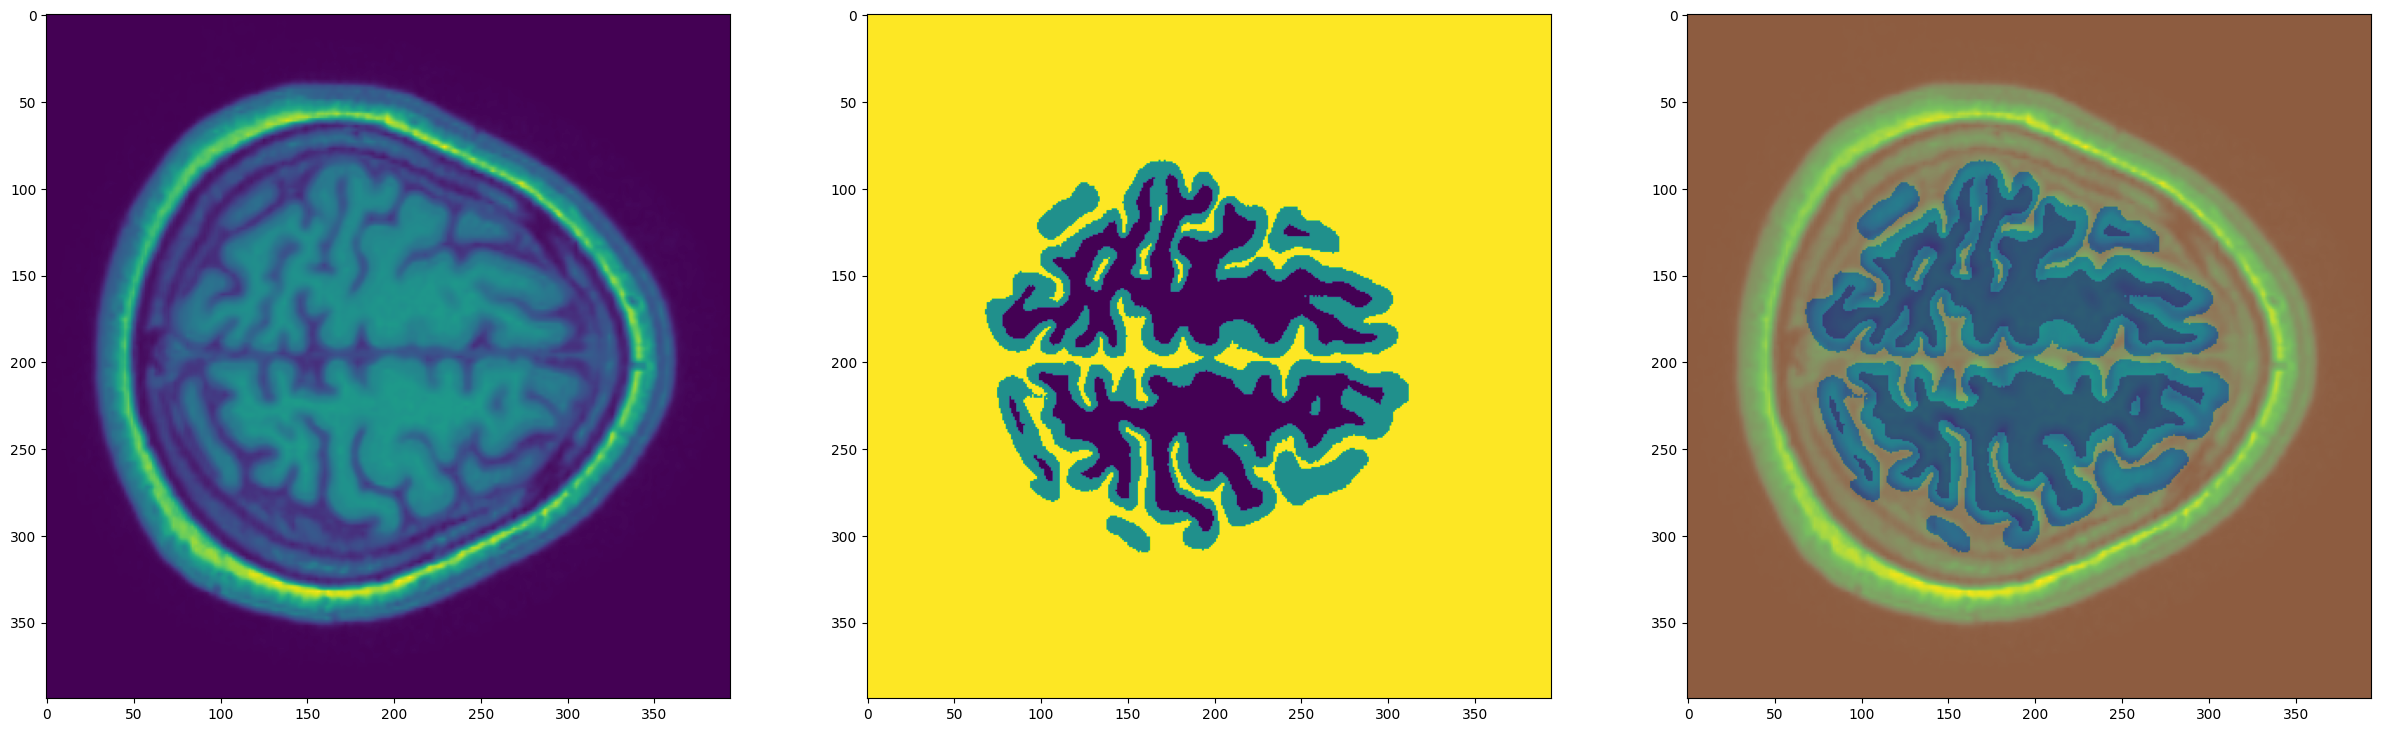

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [3]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.1462643, 0.00025629325)

In [4]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

In [19]:
mask_oh = (np.arange(3) == mask[..., None]).astype(np.float32)
mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

In [5]:
import torch
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

/media/andres/Apacer PHD/portafolio/unet_segmentation/venv_unet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )


def enconder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co)
    )


class deconv(torch.nn.Module):
    def __init__(self, ci, co) -> None:
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [8]:
def iou(outputs, labels):
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1):
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [20]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)
img_tensor.shape, mask_tensor.shape

(torch.Size([1, 1, 394, 394]), torch.Size([1, 3, 394, 394]))

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3) -> None:
        self.X = X
        self.y = y
        self.n_classes = n_classes

    
    def __len__(self):
        return len(self.X)

    
    def __getitem__(self, ix):
        img = np.load(self.X[ix])
        mask = np.load(self.y[ix])
        img = torch.tensor(img).unsqueeze(0)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)
        return img, torch.from_numpy(mask).permute(2,0,1)

In [10]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [11]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=8, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=16, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([8, 1, 394, 394]), torch.Size([8, 3, 394, 394]))

In [12]:
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo) -> None:
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

In [13]:
class UNetResNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1) -> None:
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
            self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, bias=False)

        self.deconv1 = deconv(512, 256)
        self.deconv2 = deconv(256, 128)
        self.deconv3 = deconv(128, 64)

        self.out = out_conv(64, 64, n_classes)
    

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='unet_resnet_checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [15]:
import wandb

wandb.init(project="unet_resnet_segmentation", entity="andresrestrepo")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andresrestrepo. Use `wandb login --relogin` to force relogin


In [16]:
from tqdm import tqdm
from torchvision.utils import make_grid

def fit(model, dataloader, epochs=100, lr=3e-4, patience=3, pretrained=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if pretrained:
        print("Load pretrained model checkpoint.pt")
        model.load_state_dict(torch.load('checkpoints/checkpoint.pt'))
    model.to(device)
    hist = {'loss': [], 'iou':[], 'test_loss': [], 'test_iou': []}
    early_stopping = EarlyStopping(patience=5, verbose=True, path='checkpoints/checkpoint.pt')
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            avg_train_loss = np.mean(train_loss)
            bar.set_description(f"loss {avg_train_loss:.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                avg_test_loss = np.mean(test_loss)
                bar.set_description(f"test_loss {avg_test_loss:.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        early_stopping(avg_test_loss, model)
        wandb.log({'training_loss': np.mean(train_loss), 'training_iou':np.mean(train_iou), 'test_loss': np.mean(test_loss), 'test_iou': np.mean(test_iou)})
        wandb.watch(model, log="all")
        output = y_hat[-1]
        pred_mask = torch.argmax(output, axis=0)
        mask_value = torch.argmax(masks[-1], axis=0)
        grid_images = torch.hstack([imgs[-1].squeeze(0), mask_value.squeeze(), pred_mask.squeeze()])
        images = wandb.Image(grid_images, caption="Image / Mask / Prediction")
        wandb.log({"examples": images})
        if early_stopping.early_stop:
            print("Early stopping Activated")
            break

    return hist

In [17]:
wandb.config = {
  "epochs": 5
}

In [18]:
model = UNetResNet()
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/41 [00:00<?, ?it/s]/tmp/ipykernel_24112/2768855575.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.44620 test_iou 0.63213: 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]



Epoch 1/30 loss 0.49807 iou 0.51889 test_loss 0.44620 test_iou 0.63213
Validation loss decreased (inf --> 0.446197).  Saving model ...


test_loss 0.33674 test_iou 0.67583: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]



Epoch 2/30 loss 0.35795 iou 0.68871 test_loss 0.33674 test_iou 0.67583
Validation loss decreased (0.446197 --> 0.336744).  Saving model ...


test_loss 0.26693 test_iou 0.69101: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]



Epoch 3/30 loss 0.29002 iou 0.71552 test_loss 0.26693 test_iou 0.69101
Validation loss decreased (0.336744 --> 0.266925).  Saving model ...


test_loss 0.21886 test_iou 0.72611: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Epoch 4/30 loss 0.23560 iou 0.74271 test_loss 0.21886 test_iou 0.72611
Validation loss decreased (0.266925 --> 0.218864).  Saving model ...


test_loss 0.18578 test_iou 0.71501: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]



Epoch 5/30 loss 0.19596 iou 0.75562 test_loss 0.18578 test_iou 0.71501
Validation loss decreased (0.218864 --> 0.185782).  Saving model ...


test_loss 0.16159 test_iou 0.71424: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]



Epoch 6/30 loss 0.16358 iou 0.77376 test_loss 0.16159 test_iou 0.71424
Validation loss decreased (0.185782 --> 0.161586).  Saving model ...


test_loss 0.13544 test_iou 0.75109: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]



Epoch 7/30 loss 0.13851 iou 0.78867 test_loss 0.13544 test_iou 0.75109
Validation loss decreased (0.161586 --> 0.135441).  Saving model ...


test_loss 0.11696 test_iou 0.77347: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Epoch 8/30 loss 0.11907 iou 0.80112 test_loss 0.11696 test_iou 0.77347
Validation loss decreased (0.135441 --> 0.116958).  Saving model ...


test_loss 0.10335 test_iou 0.79254: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]



Epoch 9/30 loss 0.10074 iou 0.82488 test_loss 0.10335 test_iou 0.79254
Validation loss decreased (0.116958 --> 0.103351).  Saving model ...


test_loss 0.10062 test_iou 0.77031: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]



Epoch 10/30 loss 0.08843 iou 0.83276 test_loss 0.10062 test_iou 0.77031
Validation loss decreased (0.103351 --> 0.100616).  Saving model ...


test_loss 0.08909 test_iou 0.78172: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]



Epoch 11/30 loss 0.07876 iou 0.84004 test_loss 0.08909 test_iou 0.78172
Validation loss decreased (0.100616 --> 0.089086).  Saving model ...


test_loss 0.08077 test_iou 0.79288: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]



Epoch 12/30 loss 0.07026 iou 0.84866 test_loss 0.08077 test_iou 0.79288
Validation loss decreased (0.089086 --> 0.080766).  Saving model ...


test_loss 0.07657 test_iou 0.79459: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]



Epoch 13/30 loss 0.06343 iou 0.85621 test_loss 0.07657 test_iou 0.79459
Validation loss decreased (0.080766 --> 0.076574).  Saving model ...


test_loss 0.07228 test_iou 0.79920: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]



Epoch 14/30 loss 0.05816 iou 0.86020 test_loss 0.07228 test_iou 0.79920
Validation loss decreased (0.076574 --> 0.072276).  Saving model ...


test_loss 0.07128 test_iou 0.78816: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Epoch 15/30 loss 0.05389 iou 0.86345 test_loss 0.07128 test_iou 0.78816
Validation loss decreased (0.072276 --> 0.071281).  Saving model ...


test_loss 0.07004 test_iou 0.79006: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]



Epoch 16/30 loss 0.04987 iou 0.86935 test_loss 0.07004 test_iou 0.79006
Validation loss decreased (0.071281 --> 0.070041).  Saving model ...


test_loss 0.07083 test_iou 0.78787: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 17/30 loss 0.04628 iou 0.87453 test_loss 0.07083 test_iou 0.78787
EarlyStopping counter: 1 out of 5


test_loss 0.06235 test_iou 0.80734: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]



Epoch 18/30 loss 0.04298 iou 0.87987 test_loss 0.06235 test_iou 0.80734
Validation loss decreased (0.070041 --> 0.062347).  Saving model ...


test_loss 0.06644 test_iou 0.78671: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Epoch 19/30 loss 0.04149 iou 0.87848 test_loss 0.06644 test_iou 0.78671
EarlyStopping counter: 1 out of 5


test_loss 0.06156 test_iou 0.80795: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]



Epoch 20/30 loss 0.03740 iou 0.89096 test_loss 0.06156 test_iou 0.80795
Validation loss decreased (0.062347 --> 0.061562).  Saving model ...


test_loss 0.06718 test_iou 0.78617: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]



Epoch 21/30 loss 0.03493 iou 0.89633 test_loss 0.06718 test_iou 0.78617
EarlyStopping counter: 1 out of 5


test_loss 0.06405 test_iou 0.79811: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]



Epoch 22/30 loss 0.03500 iou 0.89018 test_loss 0.06405 test_iou 0.79811
EarlyStopping counter: 2 out of 5


test_loss 0.05927 test_iou 0.80947: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]



Epoch 23/30 loss 0.03321 iou 0.89384 test_loss 0.05927 test_iou 0.80947
Validation loss decreased (0.061562 --> 0.059269).  Saving model ...


test_loss 0.06721 test_iou 0.78500: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]



Epoch 24/30 loss 0.03044 iou 0.90256 test_loss 0.06721 test_iou 0.78500
EarlyStopping counter: 1 out of 5


test_loss 0.06525 test_iou 0.79247: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]



Epoch 25/30 loss 0.02914 iou 0.90548 test_loss 0.06525 test_iou 0.79247
EarlyStopping counter: 2 out of 5


test_loss 0.05950 test_iou 0.80598: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]



Epoch 26/30 loss 0.02763 iou 0.90841 test_loss 0.05950 test_iou 0.80598
EarlyStopping counter: 3 out of 5


test_loss 0.06100 test_iou 0.80391: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]



Epoch 27/30 loss 0.02701 iou 0.90829 test_loss 0.06100 test_iou 0.80391
EarlyStopping counter: 4 out of 5


test_loss 0.06346 test_iou 0.79189: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch 28/30 loss 0.02668 iou 0.90747 test_loss 0.06346 test_iou 0.79189
EarlyStopping counter: 5 out of 5
Early stopping Activated


/tmp/ipykernel_24112/2768855575.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


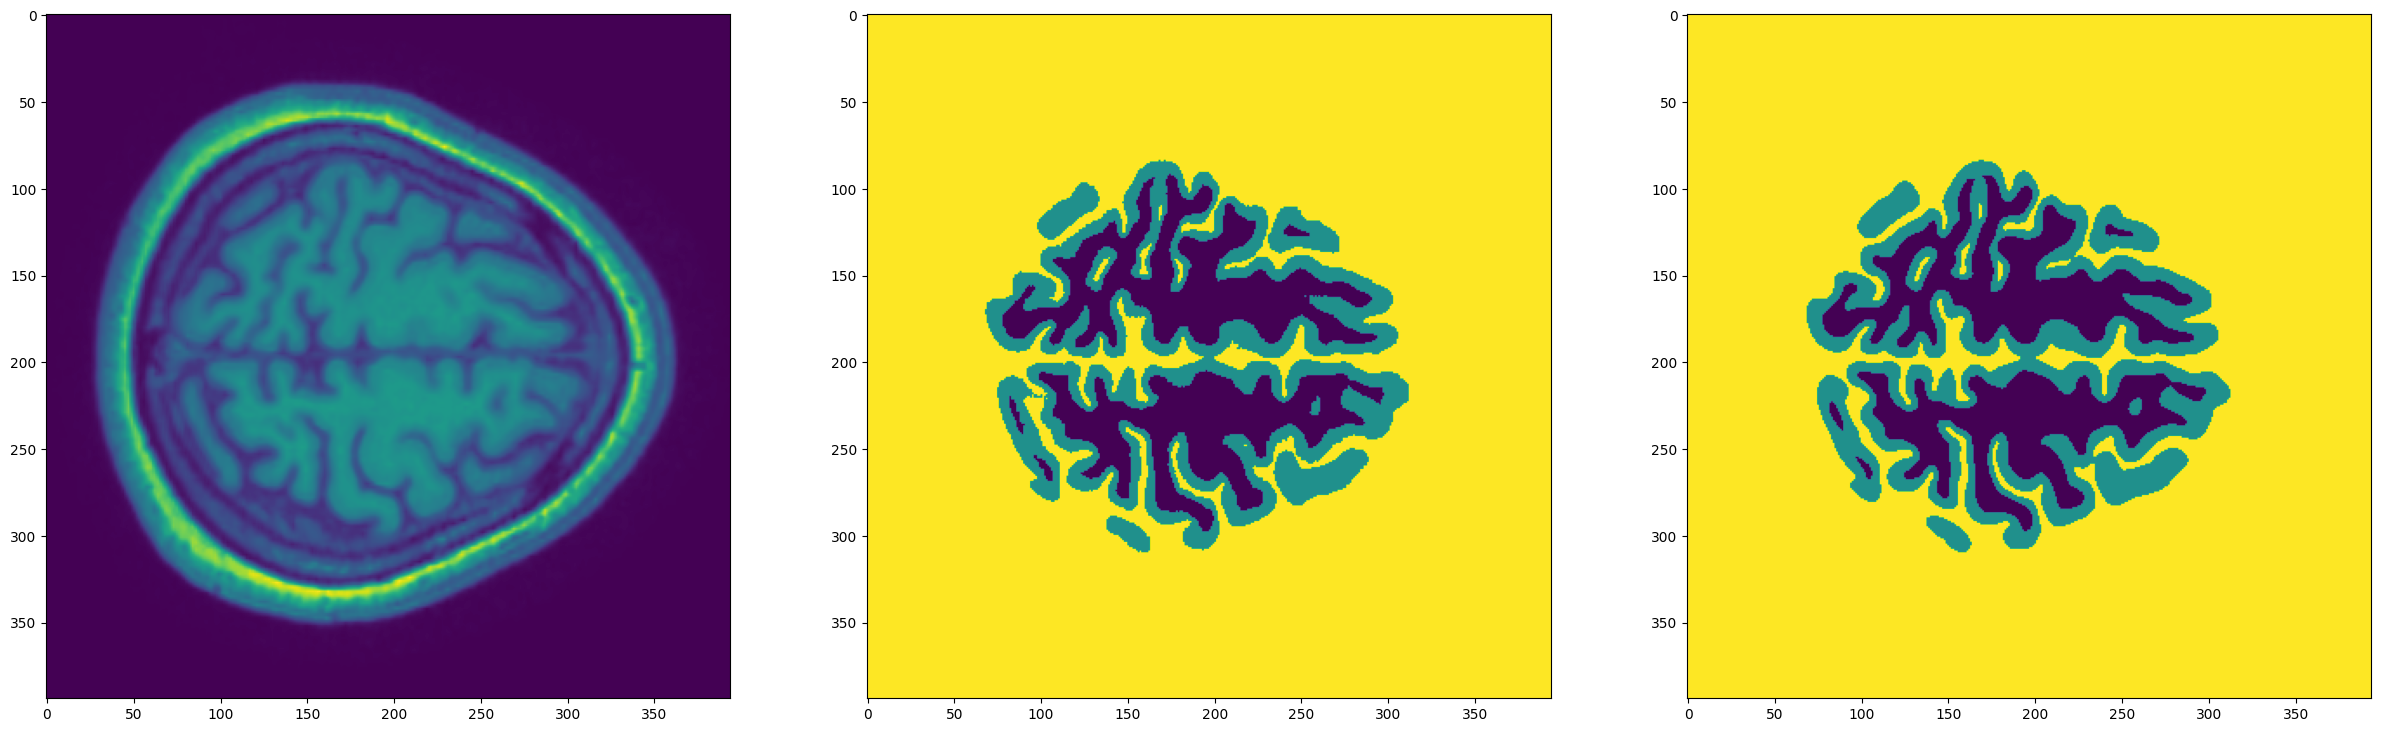

In [21]:
model = UNetResNet()
model.load_state_dict(torch.load('checkpoints/checkpoint.pt'))
model.to(device)
model.eval()

with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()